# Polynomial approximation

This notebook demonstrate how to use TensorFlow gradient tape and optimizers to approximate a polynomial to a point cloud. The main purpose is to investigate the approximation of a single polynomial as a building block for the larger splines problem.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import math

In [2]:
%load_ext autoreload
%autoreload 2
import polynomial

In [3]:
def trans_probabilities(xs):
    """Takes a sequence of numbers and makes it sum up to one."""
    xs = np.array(xs)
    return xs / sum(xs)

def l2_sq_loss(coeffs, xs, ys):
    """The squared L2 loss of given polynomial on given data points (xs, ys). Loss is
    invariant on the length of xs.""" 
    return polynomial.l2_sq_error(coeffs, xs, ys) / len(xs)

def fit(xs, ys, degree, epochs=500, **kwargs):
    """Fits a polynomial. Returns coefficients and loss sequence."""
    
    # Load initial coeffs. This overrules the degree parameter in case
    # they would not agree
    if "coeffs" not in kwargs:
        # Note: Default dtype is tf.float32!
        coeffs = [tf.Variable(0.0, dtype=tf.float64) for _ in range(degree+1)]
    else:
        coeffs = [tf.Variable(c, dtype=tf.float64) for c in kwargs["coeffs"]]
        degree = len(coeffs) - 1
    
    if "optimizer" not in kwargs:
        optimizer = keras.optimizers.SGD(learning_rate=0.1)
    else:
        optimizer = kwargs["optimizer"]

    losses = [None for _ in range(epochs)]

    # Regularize depending on degree of coefficient
    if kwargs.get("regularize_grads_degree", True):        
        reg_grads = [1.0 / (1 + i) for i in range(len(coeffs))]
    else:
        reg_grads = np.ones(len(coeffs))
    # Make gradient regularization coefficients a probability distribution.
    # This makes the sum of gradients independent of degree.
    reg_grads = trans_probabilities(reg_grads)
    
    for epoch in range(epochs): 
        with tf.GradientTape() as tape:            
            loss = l2_sq_loss(coeffs, xs, ys)
            losses[epoch] = loss.numpy()
            if kwargs.get("print_progress", False) and epoch % 10 == 0:
                print("epoch=%d, loss=%4g\r" % (epoch, loss), end="")
        grads = tape.gradient(loss, coeffs)
        grads = [g * reg_grads[i] for i, g in enumerate(grads)]
        
        optimizer.apply_gradients(zip(grads, coeffs))
        
    if kwargs.get("print_progress", False):
        print()
        
    return [c.numpy() for c in coeffs], losses

In [ ]:
def parallel_experiment_execution(job, args_per_job):
    """Return [job(args) for args in args_per_job] as numpy array,
    but runs the jobs in parallel on all CPUs."""
    
    import multiprocessing as mp
    pool = mp.Pool(mp.cpu_count())
    
    allres = pool.starmap(job, args_per_job)
    print("\nAll done.")
    
    return allres

# How is convergence influenced?

## Regularization of gradients according to coefficient degree:
**Rationale.** For a polynomial the higher-degree terms have larger impact. Hence, the gradients on
the higher-degree coefficients have larger impact, which might impair convergence. Hence, it makes
sense to regularizate them in a way to dampen gradients of higher degree. In other words, this
regularization shifts the optimization of the higher-degree coefficients to later epochs, where the
rough shape of the polynomial defined by the lower-degree coefficients brought the polynomial already
in a better shape.

**Result.** Regularization gives better convergence stability. That is, it allows for higher degrees and higher learning rates. Of course, to profit from this regularization we need polynomials of sufficient degree (e.g., 4). Then for a reasonable number of epochs the regularization improves performance, i.e., lower loss. However, since this regularization only "steers" resp. priortizes gradients towards lower degrees, after a very large number of epochs the learning curves approach each other again. (This is also an evidence that our normalization of the gradient weights, to sum up to one, works.) Furthermore, it turns out that SGD with Nesterov momentum does not converge without this regularization. With ADAM the regularization does have no influence.


## Learning rate

Having regularization turned on increases the possible range of learning rates. A rate of 0.1 turns out reasonable for our examples here. Note that a learning rate > 1.0 is in any case leading to divergence.


## Number of points to be approximted

Increasing the number of points to be approximated regulates the convergence. However, the effect is mild.


## Optimizer

Adam rocks. But SGD with appropriate momentum (and Nesterov) is quite competitive. Nesterov momentum gives a smoother decline of loss. However, Nesterov momentum _requires_ the gradient degree regularization in order to converge!

## Variation in dataset

When adding noise to the dataset both SGD and ADAM are not impaired.


## Data

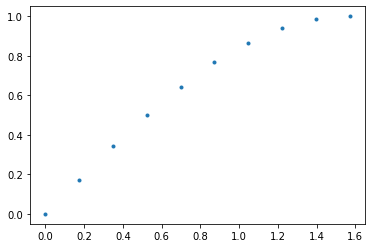

In [4]:
xss = np.linspace(0, 0.5*np.pi, 100, dtype="double")

# The data set to approximate with x and y samples
xs = np.linspace(xss[0], xss[-1], 10)
ys = np.array(np.sin(xs))
plt.plot(xs, ys, '.')

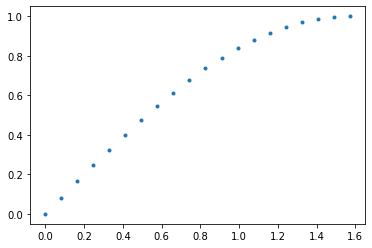

In [5]:
# The data set to approximate with x and y samples
xs2 = np.linspace(0, 0.5*np.pi, 20)
ys2 = np.sin(xs2)
plt.plot(xs2, ys2, '.')

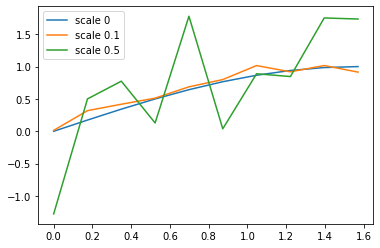

In [6]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ysgauss_scales = [0.0, 0.1, 0.5]
ysgauss = [ys + np.random.normal(scale=s, size=len(ys)) for s in ysgauss_scales]

for i, ysn in enumerate(ysgauss):
    plt.plot(xs, ysn, '-', label='scale %.2g' % ysgauss_scales[i])
plt.legend(loc="best")

## First demo

In [ ]:
# Fit with default parameters
coeffs, losses = fit(xs, ys, degree=6, print_progress=True)
coeffs2, losses2 = fit(xs, ys, degree=6, print_progress=True,\
                       optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.95, nesterov=True))
coeffs3, losses3 = fit(xs, ys, degree=6, print_progress=True, optimizer=keras.optimizers.Adam(learning_rate=0.1))

In [ ]:
ps = polynomial.evaluate_vect(coeffs, xss)
ps2 = polynomial.evaluate_vect(coeffs2, xss)
ps3 = polynomial.evaluate_vect(coeffs3, xss)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle("Polynomial degree 6")

ax1.plot(xs, ys, '.', c="black")
ax1.plot(xss, ps, label="SGD, loss=%.4g" % losses[-1])
ax1.plot(xss, ps2, label="SGD nesterov, loss=%.4g" % losses2[-1])
ax1.plot(xss, ps3, label="ADAM, loss=%.4g" % losses3[-1])

ax1.legend(loc="best")
ax1.set_title("Approximation result")

ax2.semilogy(losses, label="SGD")
ax2.semilogy(losses2, label="SGD nesterov")
ax2.semilogy(losses3, label="ADAM")
ax2.legend(loc="best")
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")

## Investigating epochs, learning rates and regularization

In [ ]:
kwargs = {"epochs": 2000, "degree": 6}
# These are the learning rates of our experiments
lrs = [(10.0**e,) for e in np.arange(-2.0, 0.01, 0.25)]

def job(lr):    
    print(".", end="")
    opt = keras.optimizers.SGD(learning_rate=lr)
    _, losses_with = fit(xs, ys, regularize_grads_degree=True, optimizer=opt, **kwargs)
    
    print("/", end="")
        
    opt = keras.optimizers.SGD(learning_rate=lr)
    _, losses_without = fit(xs, ys, regularize_grads_degree=False, optimizer=opt, **kwargs)
    
    print("#", end="")
    
    return losses_with, losses_without

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(lrs))
# allres is an array of losses with indices [learning rate, regularization with/without, epoch]
allres = np.array(parallel_experiment_execution(job, lrs))

# loss_with and loss_without are arrays with indices [learning rate, epoch]
loss_with = allres[:,0]
loss_without = allres[:,1]

In [ ]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(16)
fig.suptitle(f"Final losses after some epochs over different learning rates")

for i, epochs in enumerate([10, 100, 250, 1000]):
    ax = axes[i]
    
    ax.set_title("%d epochs" % epochs)
    
    ax.set_xlabel("learning rate")
    ax.loglog(lrs, loss_with[:, epochs-1], label="with grad. reg.")
    ax.loglog(lrs, loss_without[:, epochs-1], label="without")
    ax.set_ylim([1e-4, 1e-0])
    ax.legend(loc="best")

### Interpretation
- As we expect, at some point of the learning rate the final losses diverge. 
- With regularization we can have larger learning rates.
- **A learning rate of 0.1 seems to be a reasonable choice in either case.**

In [ ]:
fig, axes = plt.subplots(1, 5)
fig.set_figwidth(16)
fig.suptitle(f"Losses over epochs for different learning rates")

for i, lri in enumerate([0, 1, 2, 4, 5]):
    ax = axes[i]
    lr = lrs[lri]
    
    ax.set_title("learning rate %.2g" % lr)
      
    ax.semilogy(loss_with[lri], label="with grad. reg.")
    ax.semilogy(loss_without[lri], label="without")
    ax.set_ylim([5e-4, 1e-0])
    ax.legend(loc="best")

### Interpretation
- The smaller the learning rate the more epochs we need such that regularization
  eventually outperforms without regularization. However, then again with large learning rates
  (0.18) and a very large number of epochs (2000) the version without regularization may again
  overtake at some point. This is probably also true for smaller learning rates and
  a correspondingly larger number of epochs. The reason is probably that the regularization only
  introduces some "priorization" of the gradients towards lower degrees. So it is only a question
  of number epochs until this effect vanishes again.
- A learning rate of 0.1, which has before been found to be reasonable, is clearly
  large enough such that regularization outperforms without regularization after
  already some 250 epochs.
- **Activating regulariztion by default is a good choice.**
- Having some 500 epochs gives already quite good results.

## Investigating polynomial degree

In [ ]:
kwargs = {"epochs": 1000}
# These are the polynomial degrees
degrees = [(d,) for d in range(1, 9)]

def job(degree):    
    print(".", end="")
    coeffs_with, losses_with = fit(xs, ys, degree=degree, regularize_grads_degree=True, **kwargs)
    
    print("/", end="")
    coeffs_without, losses_without = fit(xs, ys, degree=degree, regularize_grads_degree=False, **kwargs)
    
    print("#", end="")
    
    return losses_with, losses_without, coeffs_with, coeffs_without

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(degrees))
allres = parallel_experiment_execution(job, degrees)
    
# loss_with and loss_without are arrays with indices [degree, epoch]
loss_with = [r[0] for r in allres]
loss_without = [r[1] for r in allres]
# coeffs_with and coeffs_without are arrays with indices [degree, coeff]
coeffs_with = [r[2] for r in allres]
coeffs_without = [r[3] for r in allres]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle("Final epoch polynomials")

ax1.set_title("with regularization")
ax2.set_title("without regularization")

for i, (d,) in enumerate(degrees):
    
    ps = polynomial.evaluate_vect(coeffs_with[i], xss)
    ax1.plot(xss, ps, label="deg %d, loss=%.4g" % (d, loss_with[i][-1]))

    ps = polynomial.evaluate_vect(coeffs_without[i], xss)
    ax2.plot(xss, ps, label="deg %d, loss=%.4g" % (d, loss_without[i][-1]))
      

for ax in [ax1, ax2]:
    ax.plot(xs, ys, ".", c="black")
    ax.legend(loc="best")
    ax.set_ylim((-0.1, 1.1))

### Interpretation

- **With regularization we can reach higher polynomial degrees.** Rationale: Once the lower-degree coefficients have brought the polynomial in rough shape then we can optimize the higher-degree coefficients more safely.
- However, the best result is obtained with a degree-3 polynomial. This comes at no surprise, because this data set displays **"low model complexity"**, so a lower degree polynomial will do better.
  Hence, we may need to look for more complex input data (like adding noise!) to showcase the usage of higher-degree polynomials. Or better: Later we will tune the optimizers that produce results closer to the optimum. And of course then we have: Higher degree is better.

In [ ]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees")

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.semilogy(loss_with[i], label="with grad. reg.")
    ax.semilogy(loss_without[i], label="without")
    ax.set_ylim([5e-4, 1e-0])
    ax.legend(loc="best")

### Interpretation
- **For degrees larger than three the regularization leads to better results.** (We know from earlier experiments that for a very large number of epocs this advantage will vanish again.)
- Of course, we would now reduce the learning rate to help higher degree polynomials to converge. But at the moment I do not see a point in doing this obvious experiment.

In [ ]:
kwargs = {"epochs": 100}
# These are the polynomial degrees
degrees = range(1, 9)
# These are the learning rates of our experiments
lrs = [10.0**e for e in np.arange(-2.0, 0.01, 0.25)]

def job(degree, lr):        
    nkwargs = kwargs
    nkwargs["degree"] = int(degree)
    
    print(".", end="")
    opt = keras.optimizers.SGD(learning_rate=lr)
    _, losses_with = fit(xs, ys, regularize_grads_degree=True, optimizer=opt, **nkwargs)
    
    print("/", end="")
    opt = keras.optimizers.SGD(learning_rate=lr)
    _, losses_without = fit(xs, ys, regularize_grads_degree=False, optimizer=opt, **nkwargs)
    
    print("#", end="")
    
    return losses_with, losses_without

args = [(d, lr) for d in degrees for lr in lrs]
print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(args))
allres = parallel_experiment_execution(job, args)

# Restore initial two dimensions [degree, learningrate, with/without reg, losses]
allres = np.array(allres)
allres = allres.reshape(len(degrees), len(lrs), *allres.shape[-2:])

In [ ]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different polynomial degrees" % kwargs["epochs"])

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
    
    loss_with = allres[i,:,0,-1]
    loss_without = allres[i,:,1,-1]
      
    ax.loglog(lrs, loss_with, label="with grad. reg.")
    ax.loglog(lrs, loss_without, label="without")
    ax.set_ylim([1e-3, 1e-0])
    ax.legend(loc="best")

### Interpretation
- Here we see how the boundary of working learning rates shifts to the left when the polynomial degree increases.
- Regularization improves the situation. A learning rate of 0.1 is a boundary case for degree-7 polynomials.
- Also interesting: Best case here is degree-4 with regularization at a learnin rate of 0.56. It is not degree-3, because degree-3 is best if we fix the learning rate.

## Investigating numer of input points

In [ ]:
kwargs = {"epochs": 1000}
# These are the polynomial degrees
degrees = [(d,) for d in range(1, 9)]

def job(degree):    
    print(".", end="")
    coeffs_with, losses_with = fit(xs2, ys2, degree=degree, regularize_grads_degree=True, **kwargs)
    
    print("/", end="")
    coeffs_without, losses_without = fit(xs2, ys2, degree=degree, regularize_grads_degree=False, **kwargs)
    
    print("#", end="")
    
    return losses_with, losses_without, coeffs_with, coeffs_without

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(degrees))
allres = parallel_experiment_execution(job, degrees)
    
# loss_with and loss_without are arrays with indices [degree, epoch]
loss_with = [r[0] for r in allres]
loss_without = [r[1] for r in allres]
# coeffs_with and coeffs_without are arrays with indices [degree, coeff]
coeffs_with = [r[2] for r in allres]
coeffs_without = [r[3] for r in allres]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle("Final epoch polynomials")

ax1.set_title("with regularization")
ax2.set_title("without regularization")

for i, (d,) in enumerate(degrees):
    
    ps = polynomial.evaluate_vect(coeffs_with[i], xss)
    ax1.plot(xss, ps, label="deg %d, loss=%.4g" % (d, loss_with[i][-1]))
    
    ps = polynomial.evaluate_vect(coeffs_without[i], xss)
    ax2.plot(xss, ps, label="deg %d, loss=%.4g" % (d, loss_without[i][-1]))
      

for ax in [ax1, ax2]:
    ax.plot(xs2, ys2, ".", c="black")
    ax.legend(loc="best")
    ax.set_ylim((-0.1, 1.1))

### Interpretation
- Increasing the numer of input points to 20 **improves convergence**, e.g., in both cases we can have a degree higher. This is not surprising: If we have d+1 points for a polynomial of degree d then the optimal solution is the interpolation polynomial. This polynomial has tendency to oscillate (for higher degrees). Adding more input points would dampen this oscillation as otherwise the L2-error with increase.
- With regularization turned on the **degree-4 polynomial is now a clear favorite**. And it is close to the best solution: degree-3 without regularizaion. Also the additional number of points makes it harder for the degree-3 polynomial to fit well.

In [ ]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees")

for i, (d,) in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.semilogy(loss_with[i], label="with grad. reg.")
    ax.semilogy(loss_without[i], label="without")
    ax.set_ylim([5e-4, 1e-0])
    ax.legend(loc="best")

### Interpretation
- The learning curves support our interpretation from above. Only with a larger number of epochs the degree-3 polynomial is probably getting better more clearly again because its curves are steeper.

In [ ]:
kwargs = {"epochs": 100}
# These are the polynomial degrees
numpoints = [4, 10, 20, 50, 100]
# These are the learning rates of our experiments
lrs = [10.0**e for e in np.arange(-2.0, 0.01, 0.25)]

def job(numpoints, lr):   
    nkwargs = kwargs
    nkwargs["degree"] = 6
        
    xs_ = np.linspace(0, 0.5*np.pi, int(numpoints))
    ys_ = np.sin(xs_)
    
    print(".", end="")
    opt = keras.optimizers.SGD(learning_rate=lr)
    _, losses_with = fit(xs_, ys_, regularize_grads_degree=True, optimizer=opt, **nkwargs)
    
    print("/", end="")
    opt = keras.optimizers.SGD(learning_rate=lr)
    _, losses_without = fit(xs_, ys_, regularize_grads_degree=False, optimizer=opt, **nkwargs)
    
    print("#", end="")
    
    return losses_with, losses_without

args = [(n, lr) for n in numpoints for lr in lrs]
print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(args))
allres = parallel_experiment_execution(job, args)

# Restore initial two dimensions [numpoints, learningrate, with/without reg, losses]
allres = np.array(allres)
allres = allres.reshape(len(numpoints), len(lrs), *allres.shape[-2:])

In [ ]:
fig, axes = plt.subplots(1, len(numpoints))
fig.set_figwidth(len(numpoints)*6)
#fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs with different number of points" % kwargs["epochs"])

for i, n in enumerate(numpoints):
    ax = axes[i]
    
    ax.set_title("number of points %d" % n)
    
    loss_with = allres[i,:,0,-1]
    loss_without = allres[i,:,1,-1]
      
    ax.loglog(lrs, loss_with, label="with grad. reg.")
    ax.loglog(lrs, loss_without, label="without")
    ax.set_ylim([1e-3, 1e-0])
    ax.legend(loc="best")

### Interpretation
- Here we see how an increasing numer of points has a positive effect on convergence, i.e., we can have higher learning rates if we have a larger number of points. However, the effect is actually moderately small.
- Interestingly, also with less than d+1 points (which would be 7 here), the method converges. But probably the polynomials are oscillating and a regulation by (square) total curvature would be needed.

## Investigating optimizers

In [ ]:
kwargs = {"epochs": 500}
opt_kwargs = {"learning_rate" : 0.1}

optimizer_creators = {
    "sgd" : lambda : keras.optimizers.SGD(**opt_kwargs),
    "sgd-momentum" : lambda : keras.optimizers.SGD(momentum=0.95, **opt_kwargs),
    "sgd-momentum-nesterov" : lambda **kwargs : keras.optimizers.SGD(momentum=0.95, nesterov=True, **opt_kwargs),
    "adam" : lambda : keras.optimizers.Adam(**opt_kwargs),
    "adam-amsgrad" : lambda : keras.optimizers.Adam(amsgrad=True, **opt_kwargs),
    "adamax" : lambda : keras.optimizers.Adamax(**opt_kwargs),
    "nadam" : lambda : keras.optimizers.Nadam(**opt_kwargs),
    "ftrl" : lambda : keras.optimizers.Ftrl(**opt_kwargs),
    "rmsprop" : lambda : keras.optimizers.RMSprop(**opt_kwargs),
}
optimizers = [(o,) for o in optimizer_creators.keys()]

def job(optimizer):
    nkwargs = kwargs
    nkwargs["degree"] = 6
        
    print(".", end="")
    opt = optimizer_creators[optimizer]()
    _, losses_with = fit(xs, ys, regularize_grads_degree=True, optimizer=opt, **nkwargs)
    
    print("/", end="")
    opt = optimizer_creators[optimizer]()
    _, losses_without = fit(xs, ys, regularize_grads_degree=False, optimizer=opt, **nkwargs)
    
    print("#", end="")
    
    return losses_with, losses_without

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(optimizers))
allres = parallel_experiment_execution(job, optimizers)
allres = np.array(allres)

In [ ]:
fig, axes = plt.subplots(3, (len(optimizers)+2)//3)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(12)
fig.suptitle("Losses over epochs with different optimizers with learning rate %.4g" % (opt_kwargs["learning_rate"]))

for i, opt in enumerate(optimizers):
    ax = axes[i]
    
    ax.set_title("%s" % opt)
    
    loss_with = allres[i,0]
    loss_without = allres[i,1]
      
    ax.semilogy(loss_with, label="with grad. reg.")
    ax.semilogy(loss_without, label="without")
    ax.set_ylim([1e-5, 1e-0])
    ax.legend(loc="best")

### Non-parallel version to recreate reduced plot for journal paper on Windows

In [7]:
kwargs = {"epochs": 5000}
opt_kwargs = {"learning_rate" : 0.1}

optimizer_creators = {
    "sgd-momentum" : lambda : keras.optimizers.SGD(momentum=0.95, **opt_kwargs),
    "sgd-momentum-nesterov" : lambda **kwargs : keras.optimizers.SGD(momentum=0.95, nesterov=True, **opt_kwargs),
    "adam" : lambda : keras.optimizers.Adam(**opt_kwargs),
    "adam-amsgrad" : lambda : keras.optimizers.Adam(amsgrad=True, **opt_kwargs)
}
optimizers = [(o,) for o in optimizer_creators.keys()]

allres = []
kwargs["degree"] = 6

for o in optimizer_creators:
    opt = optimizer_creators[o]()
    print(".", end="")
    _, losses_with = fit(xs, ys, regularize_grads_degree=True, optimizer=opt, **kwargs)
    print("/", end="")
    opt = optimizer_creators[o]()
    _, losses_without = fit(xs, ys, regularize_grads_degree=False, optimizer=opt, **kwargs)
    print("#", end="")
    allres.append((losses_with, losses_without))

allres = np.array(allres)

./#./#./#./#

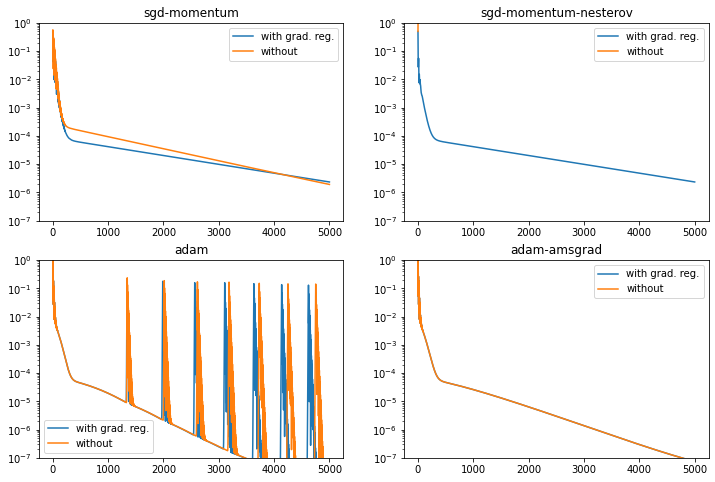

In [11]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(8)
#fig.suptitle("Losses over epochs with different optimizers with learning rate %.4g" % (opt_kwargs["learning_rate"]))

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    loss_with = allres[i,0]
    loss_without = allres[i,1]

    ax.semilogy(loss_with, label="with grad. reg.")
    ax.semilogy(loss_without, label="without")
    ax.set_ylim([1e-7, 1e-0])
    ax.legend(loc="best")

plt.savefig('optimizers-overview.pdf', format='pdf', bbox_inches='tight')

### Interpretation
- Nadam becomes instable for higher learning rates, e.g., 0.1 or 0.05. It works for 0.01
- RMSprop is instable for higher learning rates, e.g., 0.1 or 0.05. It works for 0.01.
- **Gradient degree regularization becomes irrelevant** for the adam-type optimizers and for sgd with nesterov momentum.

## Investigating momentum of SGD

In [ ]:
kwargs = {"epochs": 500, "degree": 6, "regularize_grads_degree": True}
# Momentum values
momentums = [(m,) for m in [0.0, 0.75, 0.9, 0.95, 0.98]]

def job(m):
    print(".", end="")
    opt = keras.optimizers.SGD(momentum=m, learning_rate=0.1)
    coeffs, losses_without = fit(xs, ys, optimizer=opt, **kwargs)
    
    print("/", end="")
    
    opt = keras.optimizers.SGD(momentum=m, learning_rate=0.1, nesterov=True)
    coeffs, losses_with = fit(xs, ys, optimizer=opt, **kwargs)    
    print("#", end="")
    
    return losses_without, losses_with

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(momentums))
allres = parallel_experiment_execution(job, momentums)
allres = np.array(allres)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Losses over epochs with SGD and different momentum values")

for i, (m,) in enumerate(momentums):                 
    ax1.semilogy(allres[i,0], label="momentum %.2g" % m)
    ax2.semilogy(allres[i,1], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-5, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

### Interpretation
- **Nesterov momentum without gradient degree regularization fails!** Without Nesterov, convergence works in both cases, but loss is better with regularization turned on.
- Choosing an appropriate momentum value makes SGD competitive with ADAM. **A momentum of 0.95 seams reasonable.**
- Using Nesterov leads to smoother declines of the loss function.

## Investigating ADAM

In [ ]:
kwargs = {"epochs": 100, "degree": 6}
# These are the learning rates of our experiments
lrs = [(10.0**e,) for e in np.arange(-2.0, 0.01, 0.1)]

def job(lr):
    print(".", end="")
    opt = keras.optimizers.Adam(learning_rate=lr)
    coeffs, losses_without = fit(xs, ys, optimizer=opt, regularize_grads_degree=False, **kwargs)
    
    print("/", end="")
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    coeffs, losses_with = fit(xs, ys, optimizer=opt, regularize_grads_degree=True, **kwargs)    
    print("#", end="")
    
    return losses_without, losses_with

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(lrs))
allres = parallel_experiment_execution(job, lrs)
allres = np.array(allres)

In [ ]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Final loss after %d epochs over learning rate" % kwargs["epochs"])

ax.loglog(lrs, allres[:,0,-1], label="without")
ax.loglog(lrs, allres[:,1,-1], label="with grad. reg.")
ax.set_xlabel("learning rate")
ax.set_ylabel("final loss")
ax.legend(loc="best")

### Interpretation
- ADAM is quite robust about choosing too large learning rate
- Learning rate of 0.1 is a very good choice.
- Regularization does not matter

In [ ]:
kwargs = {"epochs": 400, "degree": 6}
# These are the learning rates of our experiments
beta_1s = [(b,) for b in np.arange(0.6, 1.001, 0.1)]

def job(beta1):
    print(".", end="")
    opt = keras.optimizers.Adam(beta_1=beta1, learning_rate=0.1)
    coeffs, losses_without = fit(xs, ys, optimizer=opt, regularize_grads_degree=False, **kwargs)
    
    print("/", end="")
    
    opt = keras.optimizers.Adam(beta_1=beta1, learning_rate=0.1)
    coeffs, losses_with = fit(xs, ys, optimizer=opt, regularize_grads_degree=True, **kwargs)    
    print("#", end="")
    
    return losses_without, losses_with

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(beta_1s))
allres = parallel_experiment_execution(job, beta_1s)
allres = np.array(allres)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Losses over epochs with ADAM and different beta_1 values")

for i, (b1,) in enumerate(beta_1s):                 
    ax1.semilogy(allres[i,0], label="beta1 %.2g" % b1)
    ax2.semilogy(allres[i,1], label="beta1 %.2g" % b1)

for ax in (ax1, ax2):
    ax.set_ylim([1e-5, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Without regularization")
ax2.set_title("With regularization")

### Interpretation
- Again, regularization does not matter.
- Choosing beta1 too large or too small causes instabilities.
- The default of 0.9 is quite good. Choosing 0.8 gives better performance at first, but then, quite lately, it becomes instable.

## Stability under noise for SGD with Nesterov momentum

In [ ]:
kwargs = {"epochs": 400, "degree": 6}
idxs = [(i,) for i in range(len(ysgauss))]

def job(idx):
    print(".", end="")
    opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.95, nesterov=True)
    coeffs, losses = fit(xs, ysgauss[idx], optimizer=opt, **kwargs)    
    print("#", end="")
    
    return coeffs, losses

print("Going to run %d jobs in parallel (. for start, # for end):" % len(idxs))
allres = parallel_experiment_execution(job, idxs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("SGD with mommentum and Nesterov for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i, (coeffs, losses) in enumerate(allres):
    col = next(colcycle)["color"]
    ps = polynomial.evaluate_vect(coeffs, xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = polynomial.l2minmizer(xs, ysg, kwargs["degree"])
    psopt = polynomial.evaluate_vect(optcoeff, xss)
    optloss = l2_sq_loss(optcoeff, xs, ysg)
        
    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2) 
    
    ax2.semilogy(losses, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=kwargs["epochs"], linestyle="--", color=col, alpha=0.2)    
    
ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-5,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

### Interpretation
- Without noise the optimal error is basically zero.
- With noise SGD is approaching the optimum, but does not reach it. The gap is only significant for larger noise levels, but in practice we would not try to regress such a point cloud with such a polynomial. In this experiment we only investigated whether it would converge at all.
- Furthermore, for scale=0.5, the optimum is already showing **significant oscillation**. Hence, in the application domain of cam design, this is actually not favorable and hence we do not care so much. If we add a measurement of oscillation to the loss then the optimum would actually be closer to our iterative solutions.
- Below we see that we get basically the same results for ADAM.

In [ ]:
kwargs = {"epochs": 100, "degree": 6}
# These are the learning rates of our experiments
lrs = [10.0**e for e in np.arange(-2.0, 0.01, 0.1)]
idxs = [i for i in range(len(ysgauss))]

def job(lr, idx):
    print(".", end="")
    opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.95, nesterov=True)
    _, losses_with = fit(xs, ysgauss[idx], optimizer=opt, regularize_grads_degree=True, **kwargs)
    
    print("/", end="")
    
    opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.95, nesterov=True)
    _, losses_without = fit(xs, ysgauss[idx], optimizer=opt, regularize_grads_degree=False, **kwargs)    
    
    print("#", end="")
    
    return losses_with, losses_without

args = [(lr, i) for i in idxs for lr in lrs]
print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(args))
allres = parallel_experiment_execution(job, args)
allres = np.array(allres)
allres = allres.reshape(len(idxs), len(lrs), *allres.shape[-2:])

In [ ]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.suptitle("Final loss after %d epochs over learning rate" % kwargs["epochs"])

for i in idxs:
    ax = axs[i]
    scale = ysgauss_scales[i]
    ax.loglog(lrs, allres[i,:,0,-1], label="with grad. reg.")
    ax.loglog(lrs, allres[i,:,1,-1], label="without")
    
    ax.set_ylim([1e-4, 1e1])    
    ax.set_title("scale %.2g" % scale)
    ax.set_xlabel("learning rate")
    ax.legend(loc="best")

### Interpretation
- Once again, regularization is good
- Noise level has no impact here

## Stability under noise for ADAM

In [ ]:
kwargs = {"epochs": 400, "degree": 6}
idxs = [(i,) for i in range(len(ysgauss))]

def job(idx):    
    print(".", end="")    
    opt = keras.optimizers.Adam(learning_rate=0.1)
    coeffs, losses = fit(xs, ysgauss[idx], optimizer=opt, **kwargs)    
    print("#", end="")
    
    return coeffs, losses

print("Going to run %d jobs in parallel (. for start, # for end):" % len(idxs))
allres = parallel_experiment_execution(job, idxs)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("ADAM for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i, (coeffs, losses) in enumerate(allres):
    col = next(colcycle)["color"]
    ps = polynomial.evaluate_vect(coeffs, xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = polynomial.l2minmizer(xs, ysg, kwargs["degree"])
    psopt = polynomial.evaluate_vect(optcoeff, xss)
    optloss = l2_sq_loss(optcoeff, xs, ysg)
        
    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2) 
    
    ax2.semilogy(losses, label="scale %g, optloss=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=kwargs["epochs"], linestyle="--", color=col, alpha=0.2)    
    
ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-5,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

### Interpretation
- The same as for SGD

In [ ]:
kwargs = {"epochs": 100, "degree": 6}
# These are the learning rates of our experiments
lrs = [10.0**e for e in np.arange(-2.0, 1.01, 0.1)]
idxs = [i for i in range(len(ysgauss))]

def job(lr, idx):    
    print(".", end="")    
    opt = keras.optimizers.Adam(learning_rate=lr)
    coeffs, losses = fit(xs, ysgauss[idx], optimizer=opt, **kwargs)    
    print("#", end="")
    
    return losses

args = [(lr, i) for i in idxs for lr in lrs]
print("Going to run %d jobs in parallel (. for start, # for end):" % len(args))
allres = parallel_experiment_execution(job, args)
allres = np.array(allres)
allres = allres.reshape(len(idxs), len(lrs), *allres.shape[-1:])

In [ ]:
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.suptitle("Final loss after %d epochs over learning rate" % kwargs["epochs"])

for i in idxs:
    ax = axs[i]
    scale = ysgauss_scales[i]
    ax.loglog(lrs, allres[i,:,-1])
    
    ax.set_title("scale %.2g" % scale)
    ax.set_xlabel("learning rate") 

### Interpretation
- Note that we increased learning rate to over 10 here!
- Increasing noise, at least on these three experiments, has no significant impact on ADAM in terms of what are admissible learning rates.
- In fact, it seems as if higher noise actually makes higher learning rates possible or at least smoothens the above curves. The rationale behind this is probably that with higher noise the optimal solution already has "significant" error. Due to this large error the relative error changes for certain changes of the polynomial coefficients are therefore smaller.

## Revisit degree with better optimizer

In [ ]:
kwargs = {"epochs": 800}
# These are the polynomial degrees
degrees = [(d,) for d in range(1, 9)]

def job(degree):        
    nkwargs = kwargs
    nkwargs["degree"] = int(degree)
    
    print(".", end="")
    opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.95, nesterov=True)
    _, losses_sgd = fit(xs, ys, regularize_grads_degree=True, optimizer=opt, **nkwargs)
    
    print("/", end="")
    opt = keras.optimizers.Adam(learning_rate=0.1)
    _, losses_adam = fit(xs, ys, regularize_grads_degree=False, optimizer=opt, **nkwargs)
    
    print("#", end="")
    
    return losses_sgd, losses_adam

print("Going to run %d jobs in parallel (. for start, / for half-end, # for end):" % len(degrees))
allres = parallel_experiment_execution(job, degrees)
allres = np.array(allres)

In [ ]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees")

for i, (d,) in enumerate(degrees):
    ax = axes[i]
    
    optcoeff = polynomial.l2minmizer(xs, ys, d)    
    optloss = l2_sq_loss(optcoeff, xs, ys)
    
    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))
      
    ax.semilogy(allres[i,0], label="SGD loss=%.3e" % allres[i,0,-1])
    ax.semilogy(allres[i,1], label="Adam loss=%.3e" % allres[i,1,-1])
    
    ax.hlines(optloss, xmin=0, xmax=kwargs["epochs"], linestyle="--", color="gray", alpha=0.2)   
    
    ax.set_ylim([1e-7, 1e-0])
    ax.legend(loc="best")

### Interpretation
- With degree 1 and 2 the optimizers actually reach the optimum.
- Higher degree leads to better optimal loss, of course.
- With better optimizers we get closer to the optimum. Hence, we see that higher-degree polynomials leading to better loss. In fact, for Adam now degree 5 leads the best result and with more epochs it would be degree 4. For SGD degree 5 is best. So better optimizers shift the boundary of admissible degrees.
- SGD is competitive with Adam until degree 3. For degree 2 it is actually prefred over Adam. Then, starting from 200 epochs, Adam outperforms SGD.
- Furthermore, Adam converges for degree 8 as well. Here the degree-based regularization of gradients becomes, so it seems, insufficient, while Adam is adaptive.
- **For our cam application: Shall we better use polynomial degree 5?**